In [3]:
import pandas as pd
train_raw = pd.read_csv("train_raw.csv")
test_raw  = pd.read_csv("test_raw.csv")


In [4]:
target_col = "Survived"

y_train = train_raw[target_col].copy()
X_train = train_raw.drop(columns=[target_col]).copy()

y_test = test_raw[target_col].copy()
X_test = test_raw.drop(columns=[target_col]).copy()

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test :", X_test.shape)
print("y_test :", y_test.shape)

X_train: (668, 19)
y_train: (668,)
X_test : (223, 19)
y_test : (223,)


In [5]:
X_train = X_train.drop(columns=["title"], errors="ignore")
X_test = X_test.drop(columns=["title"], errors="ignore")

categorical_cols = [
    "Sex",
    "Embarked",
    "Pclass",
    "title_group",
    "cabin_deck",
    "is_alone",
]

numeric_cols = [c for c in X_train.columns if c not in categorical_cols]

print("Categorical columns:", categorical_cols)
print("Numerical columns: ", numeric_cols)

Categorical columns: ['Sex', 'Embarked', 'Pclass', 'title_group', 'cabin_deck', 'is_alone']
Numerical columns:  ['Age', 'SibSp', 'Parch', 'Fare', 'name_length', 'family_size', 'ticket_group_size', 'fare_per_person', 'age_fare_ratio', 'cabin_room_number', 'cabin_score', 'name_word_count']


In [6]:
missing = [c for c in categorical_cols if c not in X_train.columns]
print("Missing categorical columns:", missing)

Missing categorical columns: []


In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

knn_clf = KNeighborsClassifier()

knn_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", knn_clf),
])


In [8]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42,
)

param_grid = {
    "model__n_neighbors": [3, 5, 7, 9, 11, 15, 21, 31],
    "model__weights": ["uniform", "distance"],
}

grid_search = GridSearchCV(
    estimator=knn_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
)

grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best CV accuracy:", grid_search.best_score_)

Best params: {'model__n_neighbors': 5, 'model__weights': 'uniform'}
Best CV accuracy: 0.8068566939737403


In [9]:
import pandas as pd

cv_results_df = pd.DataFrame(grid_search.cv_results_)
cv_results_df[[
    "param_model__n_neighbors",
    "param_model__weights",
    "mean_test_score",
    "std_test_score",
    "rank_test_score",
]].sort_values("rank_test_score").head()

,param_model__n_neighbors,param_model__weights,mean_test_score,std_test_score,rank_test_score
2,5,uniform,0.806857,0.022600,1
10,15,uniform,0.805398,0.018178,2
11,15,distance,0.803905,0.015765,3
8,11,uniform,0.802390,0.028967,4
12,21,uniform,0.799394,0.017355,5


In [10]:
cv_results_df.to_csv("tables/knn_cv_results.csv", index=False)

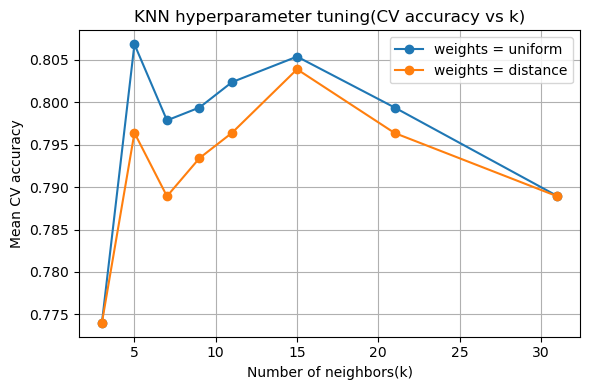

In [11]:
import matplotlib.pyplot as plt
k_values = cv_results_df["param_model__n_neighbors"].astype(int)
weights = cv_results_df["param_model__weights"].astype(str)
mean_scores = cv_results_df["mean_test_score"]

plt.figure(figsize=(6, 4))

for w in ["uniform", "distance"]:
    mask = (weights == w)
    plt.plot(
        k_values[mask],
        mean_scores[mask],
        marker="o",
        label=f"weights = {w}",
    )

plt.xlabel("Number of neighbors(k)")
plt.ylabel("Mean CV accuracy")
plt.title("KNN hyperparameter tuning(CV accuracy vs k)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("plots/knn_cv_accuracy.png", dpi=300)
plt.show()

In [13]:
from sklearn.metrics import accuracy_score

best_params = grid_search.best_params_
best_cv_acc = grid_search.best_score_

print("Best params from CV:", best_params)
print("Best mean CV accuracy:", best_cv_acc)

final_knn_model = grid_search.best_estimator_

y_train_pred = final_knn_model.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)

print("Training accuracy of final KNN model:", train_acc)

Best params from CV: {'model__n_neighbors': 5, 'model__weights': 'uniform'}
Best mean CV accuracy: 0.8068566939737403
Training accuracy of final KNN model: 0.8592814371257484


In [16]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
import pandas as pd
import matplotlib.pyplot as plt

y_test_pred = final_knn_model.predict(X_test)

test_acc = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("KNN performance on test set:")
print("Accuracy :", test_acc)
print("Precision:", test_precision)
print("Recall   :", test_recall)
print("F1-score :", test_f1)

KNN performance on test set:
Accuracy : 0.7982062780269058
Precision: 0.759493670886076
Recall   : 0.6976744186046512
F1-score : 0.7272727272727273


In [17]:
X_train_transformed = final_knn_model.named_steps["preprocess"].transform(X_train)
n_features_final = X_train_transformed.shape[1]
print("Number of features after preprocessing:", n_features_final)

Number of features after preprocessing: 36


In [19]:
knn_perf_df = pd.DataFrame({
    "model": ["KNN"],
    "n_neighbors": [grid_search.best_params_["model__n_neighbors"]],
    "weights": [grid_search.best_params_["model__weights"]],
    "n_features": [n_features_final],
    "test_accuracy": [test_acc],
    "test_precision": [test_precision],
    "test_recall": [test_recall],
    "test_f1": [test_f1],
})
knn_perf_df.head()

,model,n_neighbors,weights,n_features,test_accuracy,test_precision,test_recall,test_f1
0,KNN,5,uniform,36,0.798206,0.759494,0.697674,0.727273


In [20]:
knn_perf_path = "tables/knn_test_performance.csv"
knn_perf_df.to_csv(knn_perf_path, index=False)

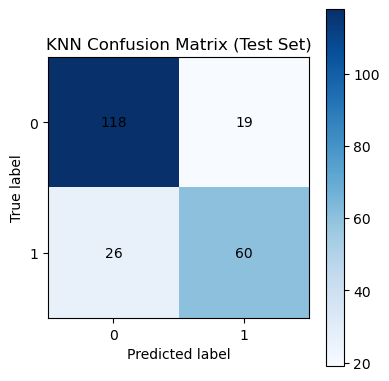

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(4, 4))
plt.imshow(cm, cmap="Blues")
plt.title("KNN Confusion Matrix(Test Set)")
plt.colorbar()

classes = [0, 1]
tick_marks = range(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted label")
plt.ylabel("True label")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
cm_path = "plots/knn_confusion_matrix.png"
plt.savefig(cm_path, dpi=300)
plt.show()


In [22]:
from sklearn.inspection import permutation_importance

r = permutation_importance(
    final_knn_model,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
)

feat_imp = pd.DataFrame({
    "feature": X_test.columns,
    "mean_importance": r.importances_mean,
    "std_importance": r.importances_std,
}).sort_values("mean_importance", ascending=False)

feat_imp.head()

,feature,mean_importance,std_importance
1,Sex,0.051121,0.013181
8,title_group,0.046188,0.012371
2,Age,0.029596,0.008787
11,ticket_group_size,0.027354,0.009069
0,Pclass,0.012556,0.005601


In [23]:
feat_imp_path = "tables/knn_feature_importance.csv"
feat_imp.to_csv(feat_imp_path, index=False)

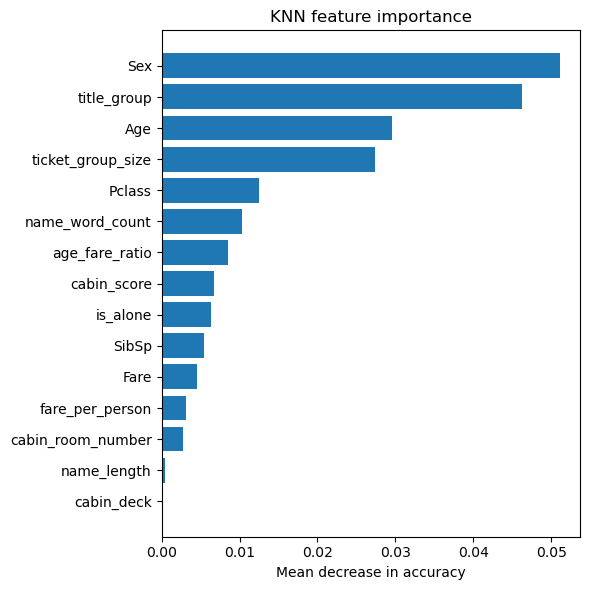

In [24]:
top_k = 15
top_feat = feat_imp.head(top_k)

plt.figure(figsize=(6, 6))
plt.barh(top_feat["feature"], top_feat["mean_importance"])
plt.xlabel("Mean decrease in accuracy")
plt.title("KNN feature importance")
plt.gca().invert_yaxis()  
plt.tight_layout()

fi_plot_path = "plots/knn_feature_importance_top15.png"
plt.savefig(fi_plot_path, dpi=300)
plt.show()